# FOCUS COVID
----

In [1]:
from collections import Counter
import os
from os.path import join
import pprint
import re
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import nltk
from nltk.corpus import stopwords
import numpy as np
from gensim.models.phrases import Phrases
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec
import pandas as pd
import preprocessor as p
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import tqdm
from wordcloud import WordCloud

pd.set_option("max_colwidth", None)

In [2]:
more_swfr = set([
    "si", "ça", "tout", "peut", "plus", "cb", "va", "être", "oui", "non", "mai", "quand", "chez", "car",
    "aussi", "cet", "cette", "ce", "ca", "donc", "comme", "jusqu", "pendant", "avoir", "pq", "là", "lui", "moi",
    "dit", "dis", "tous", "toutes", "trop", "vu", "viens", "quoi", "quel", "pr",  "bah", "amp", "ah", "encore",
    "juste", "après", "rien", "a", "où", "moins", "déjà", "avant", "très", "ceux", "celles", "ces", "leur", 
    "leurs", "dès", "selon", "elle", "elles", "autres", "près", "vers", "afin", "ainsi", "peux", "aller", 
    "vient", "fait", "faut", "faire", "vont", "viennent",
])

swfr = set(stopwords.words('french')) | more_swfr

### FUNCTIONS

In [ ]:
def make_query(what, how):
    return " OR ".join(what) + " AND " + " OR ".join(how)


def is_word_around(sentence, word, tokens, wsize=5):
    splitted = sentence.split()
    positions = [i for (i, w) in enumerate(splitted) if w in tokens]
    windows_words_list = [splitted[(pos-wsize):(pos+wsize)] for pos in positions]
    return len([window_words for window_words in windows_words_list if word in window_words])


def encode_covid(string, pattern="corona\W?virus|covid\W?19|covid|virus"):
    return re.sub(pattern=pattern, repl="COVID19", string=string)


def most_similar(WORDS, verbose=True):
    wv_df = pd.concat([
    pd.DataFrame(model.wv.most_similar(word), columns=["associated_word", "similarity"]).assign(word=word) for word in FEAR_strict
    ])
    if verbose:
        for g, dfg in wv_df.groupby("word"):
            print(g, ":")
            print("\t", ", ".join(dfg.associated_word.tolist()))
    return wv_df


class TweetCorpus:
    """An interator that yields sentences (lists of str)."""
    
    def __init__(self, df):
        self.df = df
    
    def __iter__(self):
        for tweet in self.df.clean_tweet_ngram:
            # assume there's one document per line, tokens separated by whitespace
            tweet = [w for w in tweet.split() if w not in swfr]
            yield tweet


def import_df(path_cash, path_cb):
    print("Import dfs")
    df_cash = pd.read_pickle(path_cash)
    df_cb = pd.read_pickle(path_cb)

    print(df_cash.shape)
    print(df_cb.shape)

    df = df_cash.assign(query="cash").append(df_cb.assign(query="cb"))

    print("Add col datetime")
    df["datetime"] = pd.to_datetime(df.date.astype(str) + " " + df.time.astype(str), errors="coerce")
    df["index"] = df["datetime"]
    df.set_index("index", inplace=True)

    print("Clean more")
    df["clean_tweet"] = (df.clean_tweet
                         .apply(lambda s: re.sub(pattern="[0-9]+", repl=" ", string=s))
                         .apply(lambda s: re.sub(pattern="@\w+", repl="", string=s))
                         .apply(lambda s: re.sub(pattern=r"///\w+", repl="", string=s))
                         .apply(lambda s: re.sub(pattern=r"[()\[\]\-#_]", repl=" ", string=s))
                         .apply(lambda tweet: tweet.replace("?", " ? ").replace("!", " ! ").replace("…", " "))
                         .apply(encode_covid)
    )
    
    return df


In [ ]:
def plot_pca_var(pca_values, i, j, feature_names, zoom=1):
    fig = plt.figure(figsize=(10, 10))
    
    ax1, ax2 = pca_values[[i, j]]
    


    # Add labels based on feature names (here just numbers)
    for x, y, txt in zip(ax1, ax2, feature_names):
        alpha = (x**2+y**2)*200
        jitter_x, jitter_y = np.random.normal(scale=0.1/10, size=2)
        plt.text(x+jitter_x, y+jitter_y, txt, ha='center', va='center', alpha=.8, size=9)

    # Add unit circle
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
    plt.gca().add_artist(circle)

    # Ensure correct aspect ratio and axis limits
    plt.axis('equal')
    plt.xlim([-1.05/zoom,1.05/zoom])
    plt.ylim([-1.05/zoom,1.05/zoom])

    # Label axes
    plt.xlabel(f'PC {i}')
    plt.ylabel(f'PC {j}')
    plt.axhline(0, alpha=.5, color="gray", linestyle="--")
    plt.axvline(0, alpha=.5, color="gray", linestyle="--")
    # Done
    #plt.show()


def plot_explained_variance(pca):
    ax = pd.Series(pca.explained_variance_ratio_).cumsum().plot(kind="bar")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    return ax

### CONSTANTS

In [3]:
WHAT_CASH = [
    'espece',  'especes', 'billets', 'billet', 'piece', 'pieces', 'monnaie', 'cash',
    'liquide', 'retraits', 'retrait', 'distributeur', 'distributeurs', '" DAB "', 'guichet', 'guichets'
]

HOW_CASH = [
    'paiement', 'paiements', 'payer', 'reglements', 'reglement', 'regler', 'achat',
    'achats', 'acheter', 'retirer', 'depenser', 'depense', 'depenses'
]

WHAT_CB = [
    'carte', 'cartes', '" CB "', '"sans contact"', '" visa "', 'mastercard',
    '"cash back"', '" NFC "', '"Google Pay"', '"ApplePay"', '"Paylib"', '"Lydia"',
    '"Lyf Pay"', '"Alipay"', '"Samsung Pay"', '"Stocard Pay"', '"paiements mobiles"', '"chèques"'
]

HOW_CB = [
    'paiement', 'paiements', 'payer', 'reglement', 'reglements', 'regler','achat', 'achats',
    'acheter', 'retirer', 'virement', 'virements', 'virer', 'depenser', 'depense', 'depenses'
]


QUERIES = dict(query_fr_cash = make_query(WHAT_CASH, HOW_CASH),
               query_fr_cb = make_query(WHAT_CB, HOW_CB))

# MODELS
PHRASE_THRESHOLD = 15
PHRASE_MIN_COUNT = 25

# GRAPHS
FIGSIZE = (10, 6)
WIDE_FIGSIZE = (12, 7)

# PATHS
BASE_PATH_FIGS = "/home/cash/output/figs/focus_covid"
BASE_PATH_W2V = "/home/cash/output/word2vec_models"

NameError: name 'make_query' is not defined

In [6]:
os.makedirs(BASE_PATH_FIGS, exist_ok=True)
os.makedirs(BASE_PATH_W2V, exist_ok=True)

pp = pprint.PrettyPrinter(compact=True, width=90)

### IMPORT DATA

In [7]:
QUERIES_PATH = "/home/cash/output/cleaned_queries"

In [8]:
df_all = import_df(
    path_cash = join(QUERIES_PATH, "without_geoloc", "query_fr_cash_cleaned.pickle"),
    path_cb = join(QUERIES_PATH, "without_geoloc", "query_fr_cb_cleaned.pickle")
)

df = import_df(
    path_cash = join(QUERIES_PATH, "with_geoloc","query_fr_cash_cleaned_geoloc.pickle"),
    path_cb = join(QUERIES_PATH, "with_geoloc", "query_fr_cb_cleaned_geoloc.pickle")
)

Import dfs
(200209, 41)
(255702, 41)
Add col datetime
Clean more
Import dfs
(70363, 48)
(104177, 48)
Add col datetime
Clean more


In [9]:
df['mask_covid_count'] = df['clean_tweet'].str.contains("pand[eé]mi|[é|e]pid[ée]mi|covid|COVID19|contamination|pand[ée]mi|virus")
df['mask_covid'] = df['mask_covid_count'] > 0

# 0. Simple plot of Covid 

La part des tweets parlant du COVID atteint jusqu'à 14% en avril. Après juillet, sa part est stable, à environ 2% des tweets.

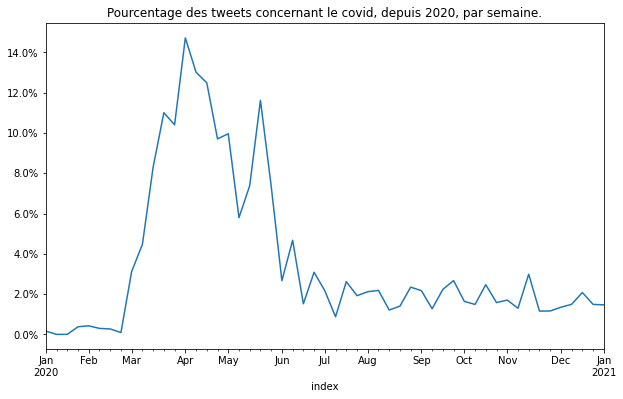

In [22]:
ax = df.loc["2020"]["mask_covid"].resample("W").mean().plot(figsize=FIGSIZE)
ax.set_title("Pourcentage des tweets concernant le covid, depuis 2020, par semaine.")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.figure.savefig(f"{BASE_PATH_FIGS}/covid_weekly_share_from_2020.jpg")

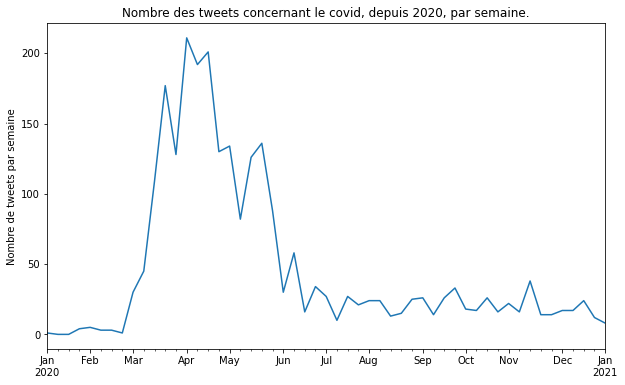

In [23]:
ax = df.loc["2020"]["mask_covid"].resample("W").sum().plot(figsize=FIGSIZE)
ax.set(ylabel="Nombre de tweets par semaine", xlabel=None)
ax.set_title("Nombre des tweets concernant le covid, depuis 2020, par semaine.")
ax.figure.savefig(f"{BASE_PATH_FIGS}/covid_weekly_count_from_2020.jpg")

# 1. Identify words related to fear of cash (due to covid)

### Train ngrams

In [80]:
%%time
# 1min30
df_all = df_all.drop_duplicates(subset="clean_tweet")
print("Training on non-restricted dataset")
phrase_model = Phrases(
    df_all.clean_tweet.apply(str.split).tolist(),
    min_count=PHRASE_MIN_COUNT, threshold=PHRASE_THRESHOLD, common_terms=swfr
)
df_all["clean_tweet_ngram"] = df_all.clean_tweet.apply(lambda tweet: " ".join(phrase_model[tweet.split()]))

# 30 sec
print("Training on restricted dataset (geolocated only)")
phrase_model = Phrases(df.clean_tweet.apply(str.split).tolist(), 
                       min_count=PHRASE_MIN_COUNT, threshold=PHRASE_THRESHOLD, common_terms=swfr)
df["clean_tweet_ngram"] = df.clean_tweet.apply(lambda tweet: " ".join(phrase_model[tweet.split()]))

Training on ALL dataset


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training on restricted dataset (geolocated only)
CPU times: user 1min 44s, sys: 2.08 s, total: 1min 46s
Wall time: 1min 46s


### Word2vec

The Word2vec is trained and the whole dataset. It yields better result than just training on the subset of France.

Process : 
- N-grams are included in the dataset
- Word2vec is trained on the whole dataset
- A pre-defined list of words linked with fear (FEAR_strict) is defined. The most similar words (based on w2v) are returned.
- These 2 lists (FEAR_strich and similar words) are concat -> FEAR_extended

In [81]:
try:
    model = Word2Vec.load(join(BASE_PATH_W2V, "w2v_s300_ngram_w5_ALL.model"))
except:
    corpus = TweetCorpus(df=df_all)
    size = 300
    window = 5
    model = Word2Vec(corpus, size=size, window=window, min_count=PHRASE_MIN_COUNT, workers=7)
    model.save(join(BASE_PATH_W2V, f"w2v_s{size}_ngram_w{window}_ALL.model"))

In [82]:
FEAR_strict = ["contamination" , "manipulation", "propagation",  "infection",  "désinfection", "transmission",
               "sanitaire",  "microbes", "vecteur", "hygiène",
               "épidémie", "pandémie", 
               #"disparition"
              ]
wv_df = most_similar(FEAR_strict, verbose=True)
#previously : df.similarity > 0.85
FEAR_extended = set(
    FEAR_strict
    + wv_df.loc[lambda df: df.similarity > .75, "associated_word"].drop_duplicates().tolist()
)# - set(["église_parisienne", "tester_la_quête", "tente_la_quête"])
pp.pprint(FEAR_extended)

contamination :
	 contagion, propagation_du_COVID19, transmission_du_COVID19, vecteur, propagation, période_de_crise, transmission, épidémie, infection, crise_sanitaire
désinfection :
	 distances, plexiglas, barrières, lavage, gel_hydroalcoolique, gel_hydro, nettoyage, distanciation, poignées, désinfecter
hygiène :
	 sanitaires, protection, respectant, distanciation, surfaces, distanciation_sociale, environnement, gestes, normes, gaspillage
infection :
	 contagion, épidémie_de_COVID19, propagation, contamination, coûter_plus_cher, propagation_du_COVID19, boosté, gouvernement_alerté, options_libre, favorisé
manipulation :
	 transmission_du_COVID19, contamination, disparition, manipuler, transmission, période_de_crise, instaurer, propagation_du_COVID19, vecteur, flux
microbes :
	 claviers, hygiénique, radars, tendent, boulangers, forêts, alcoolique, mendiants, chirurgie, propager
pandémie :
	 crise, épidémie, crise_sanitaire, propagation, COVID19, crise_du_COVID19, contamination, context

#### Output to html

In [83]:
wv_df_pretty = wv_df.groupby("word").associated_word.apply(lambda s: ", ".join(s)).reset_index()
wv_df_pretty.to_html(f"{BASE_PATH_FIGS}/words_fears.html", index=False)

### Couting occurence of FEAR_extended words in the FR dataset

In [84]:
FEAR_extended_no_covid = set(
    [w for w in FEAR_extended if "covid" not in w.lower()]
)

In [86]:
df["mask_fear_count"] = df.clean_tweet_ngram.apply(lambda sentence: len([w for w in sentence.split() if w in FEAR_extended]))
df["mask_fear"] = df.mask_fear_count >= 1
df["mask_total_covid"] = df.mask_fear | df.mask_covid

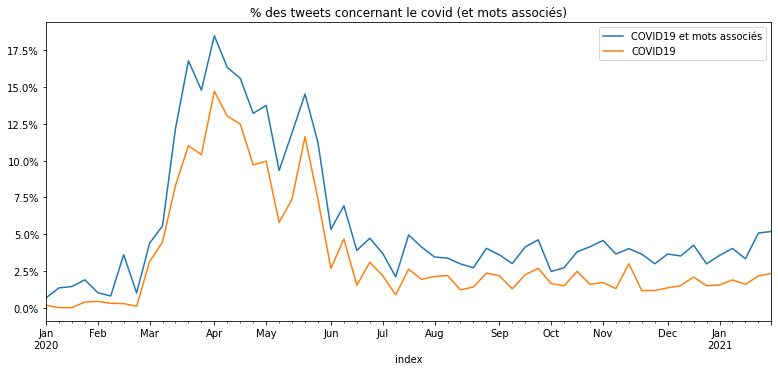

In [88]:
f, ax = plt.subplots(figsize=(13, 5.5))
df.loc["2020":].resample("W")["mask_total_covid"].mean().plot(ax=ax, label="COVID19 et mots associés")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title("% des tweets concernant le covid (et mots associés)")
df.loc["2020":]["mask_covid"].resample("W").mean().plot(ax=ax, label="COVID19")
ax.legend()
f.savefig(f"{BASE_PATH_FIGS}/covid_and_vw_weekly_share_from_2020.jpg", bbox_inches="tight")

In [90]:
df["mask_manip"] = df.clean_tweet_ngram.str.contains("mains|manipul")

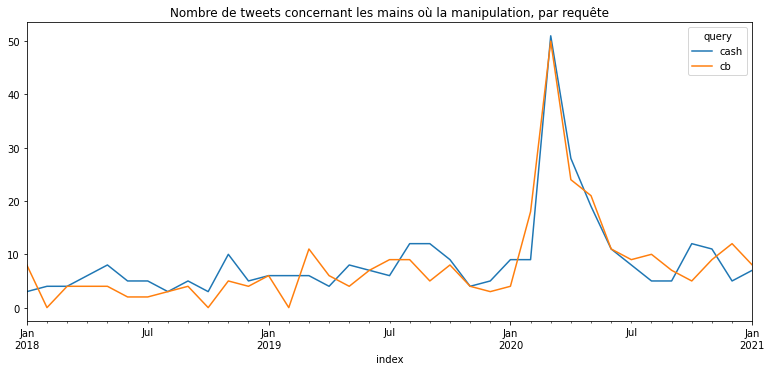

In [94]:
f, ax = plt.subplots(figsize=(13, 5.5))
ax.set_title("Nombre de tweets concernant les mains où la manipulation, par requête")
ax = df.groupby("query").resample("M")["mask_manip"].sum().unstack("query").plot(ax=ax)

### Tweets with a lots of fear words

In [73]:
high_fear_tweets = df.loc[df.mask_fear_count >= 2, "tweet"].reset_index(name="datetime").sample(10)
high_fear_tweets.to_html(join(BASE_PATH_FIGS, "high_fear_words.html"))

AttributeError: 'DataFrame' object has no attribute 'mask_fear_count'

### See context for words "manipulation" and "mains"

In [31]:
def concat(concordance):
    return f'{" ".join(concordance.left)} {concordance.query} {" ".join(concordance.right)}'

width, lines = 130, 10
example_tweets = df.loc[df.mask_fear_count >= 1, "tweet"].apply(str.split).tolist()
txt = nltk.Text([w for tweet in example_tweets for w in tweet])
for word in ["manipulation", "mains"]:
    txt.concordance(word, width=width, lines=lines)
    print("\n")

Displaying 10 of 81 matches:
. #COVIDー19 Pour payer privilégiez le sans contact. Pas de manipulation de monnaie, donc pas de risque de s’échanger une pièce ou 
er https://t.co/DbWO9bSDJ8 @CAAnjouMaine Pour minimiser la manipulation de pièces et de billets, utilisez le paiement sans contact
 compter sur nous en ces temps troublés. Pour minimiser la manipulation de pièces et de billets, utilisez le paiement sans contact
 argent liquide en invoquant le risque de contagion par la manipulation des pièces et des billets 💵 Mais peut-on vous refuser un p
ps://t.co/DmXku5X9a0 [Le conseil du jour] Afin d'éviter la manipulation d'espèces et de billets et préserver votre santé et celle 
 retraits et dépôts sont bloqués uniquement pour éviter la manipulation d'espèces aux agents et une possible infection de covid19.
macie, privilégiez le #paiement sans contact, qui évite la manipulation de pièces ou billets ! ▶️ https://t.co/9M7kEsf6ij #PUB htt
 rendez vous paiement avant par virement pour éviter t

### Wordcloud

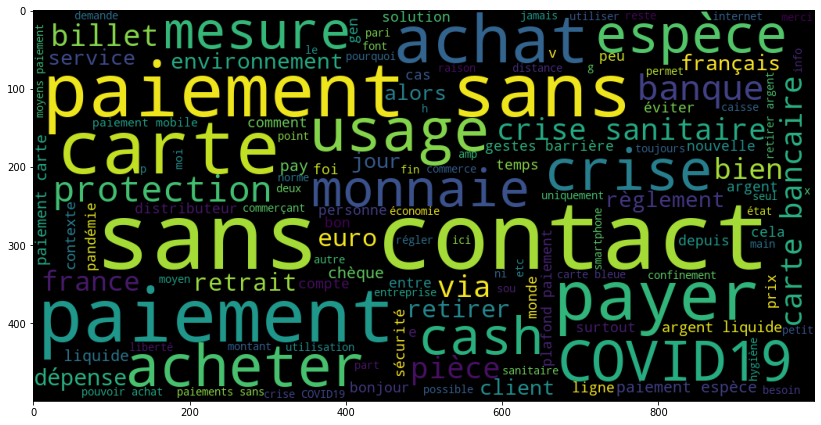

In [32]:
wc = WordCloud(width=1000, height=500, collocation_threshold=30, prefer_horizontal=.9, max_font_size=120, max_words=300, min_font_size=12)
#wc = WordCloud(width=1000, height=500)
wc.generate(
   " ".join([w for tw in df.loc[df.mask_fear >= 1].clean_tweet.dropna().apply(lambda s: [w for w in s.split() if w not in swfr]).tolist() for w in tw])
)

c=1.4
plt.subplots(figsize=(10*c, 10*c))
plt.imshow(wc)

wc.to_file(f'{BASE_PATH_FIGS}/wc_fear.png')

# 2. Work on the count of fear words

### 2.1. Building array of counts for fear words

In [99]:
terms_only = True

if terms_only:
    selected_tweet = df.clean_tweet_ngram.apply(lambda sentence: " ".join([w for w in sentence.split() if w in FEAR_extended]))#[lambda s: s!= ""]
    vectorizer = TfidfVectorizer(stop_words=swfr)
else:
    sub_df = df.loc[lambda df: df.mask_fear]
    selected_tweet = sub_df.clean_tweet_ngram#.drop_duplicates()
    vectorizer = CountVectorizer(stop_words=swfr, min_df=8/1000)

Xdf = pd.DataFrame(data=vectorizer.fit_transform(selected_tweet).toarray(),
                   columns=vectorizer.get_feature_names(),
                   index=selected_tweet.index)

Xdf["query"] = df["query"]
print("# of terms:", len(Xdf.columns))
Xdf.drop(columns="query").sum()

# of terms: 60


accéléré                    24.592376
adapte                      23.632673
alcoolique                  18.799191
barrières                   45.755652
boosté                      11.000000
boulangers                  20.171100
chirurgie                    8.000000
claviers                    22.910500
contagion                   16.539097
contamination               56.074067
contexte                   102.408058
coûter_plus_cher            31.000000
crise                      441.220945
crise_sanitaire            176.270052
directives                  20.014617
distances                   44.041655
distanciation               36.862836
déclin                      52.117372
désinfecter                 19.354494
désinfection                12.409807
environnement              113.868117
favorisé                    14.731526
forêts                      21.000000
gaspillage                  42.553858
gel_hydroalcoolique         39.852577
gestes                      48.038126
généralisé  

<AxesSubplot:xlabel='index'>

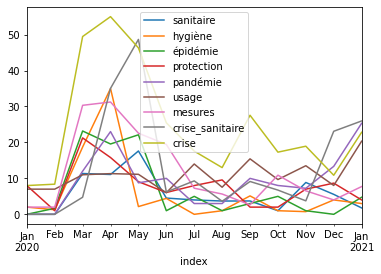

In [100]:
selected_vars = Xdf.loc["2020":].resample("M").sum().sum().sort_values()[lambda s: s>70].index
Xdf[list(selected_vars)].loc["2020":].resample("M").sum().plot()

In [101]:
l = []
nvars = 6

for g, dfg in Xdf.loc["2020":].groupby("query"):
    count_df = dfg.resample("M").sum()
    best_variable = count_df.sum().sort_values().tail(nvars).index
    l.append(
        pd.melt(count_df[best_variable].reset_index(), id_vars="index").assign(group=g)
    )

amen = pd.concat(l)

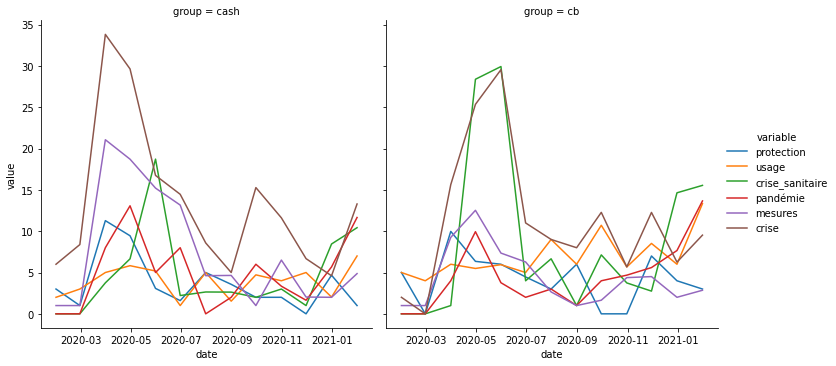

In [102]:
sns.relplot(
    data = amen.rename(columns=dict(index="date")),
    x="date", y="value",
    col="group", hue="variable", #style="variable",
    kind="line"
)

### 2.2. Plot of counts (by category)

In [103]:
d = {}

for word, dfg in wv_df.groupby("word"):
    sub_words = dfg.associated_word.tolist()
    cols = set(Xdf.columns) & set(sub_words)
    d[word] = Xdf[cols].sum(axis=1)

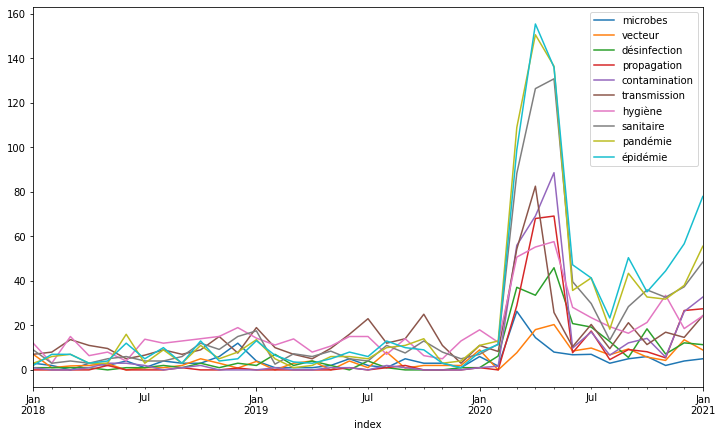

In [104]:
monthly_cat = pd.DataFrame(d).resample("M").sum()
ax = monthly_cat[monthly_cat.sum().sort_values().iloc[-10:].index].plot(figsize=WIDE_FIGSIZE)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter(100.0))

<AxesSubplot:xlabel='index'>

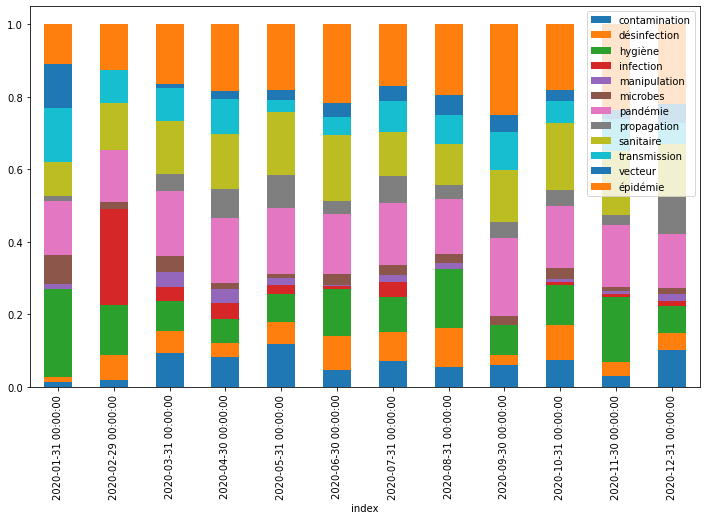

In [105]:
monthly_cat = pd.DataFrame(d).resample("M").sum()
monthly_cat["2020"].apply(lambda s: s/s.sum(), axis=1).plot.bar(stacked=True, figsize=WIDE_FIGSIZE)

### 2.3. ACP on count of categories

In [106]:
scale = True

X = Xdf.resample("D").sum().loc[lambda df: df.index >= "2020"]
pca = PCA(n_components=4)

if scale:
    sc = StandardScaler()
    indiv_pca = pca.fit_transform(sc.fit_transform(X))
else:
    indiv_pca = pca.fit_transform(X)

<AxesSubplot:>

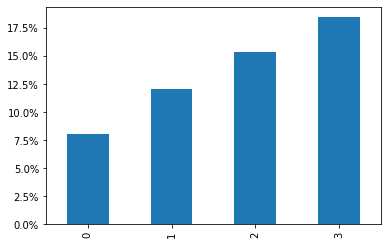

In [107]:
plot_explained_variance(pca)

In [108]:
ipca = pd.DataFrame(indiv_pca, index=X.index)
ipca.columns = ["a"+str(col) for col in ipca.columns]
ipca["year"] = pd.Series([f"{x.year}Q{(2+x.month) // 3}" for x in ipca.index.date]).tolist()

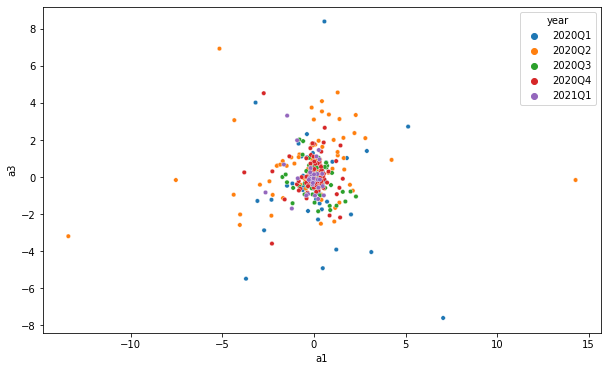

In [110]:
plt.figure(figsize=FIGSIZE)
sns.scatterplot(x="a1", y="a3", data=ipca, hue='year', s=20, alpha=1)
plt.show()

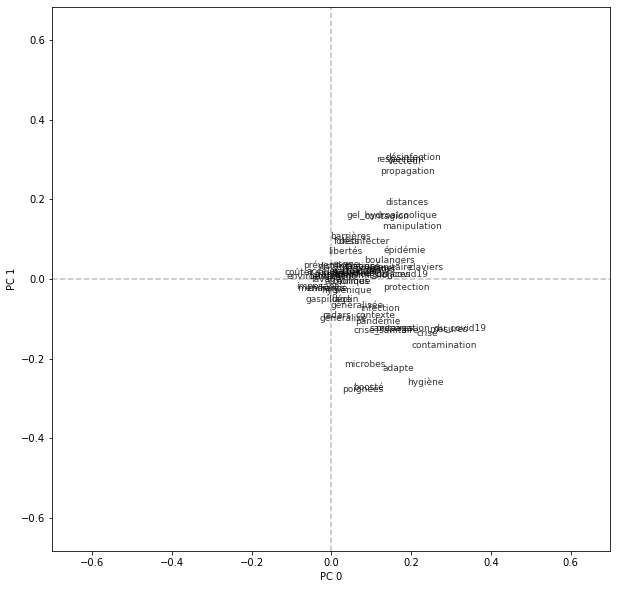

In [111]:
plot_pca_var(pca.components_, 0, 1, feature_names = Xdf.columns, zoom=1.5)
plt.savefig(join(BASE_PATH_FIGS, "pca_0_1.png"))

<AxesSubplot:xlabel='index'>

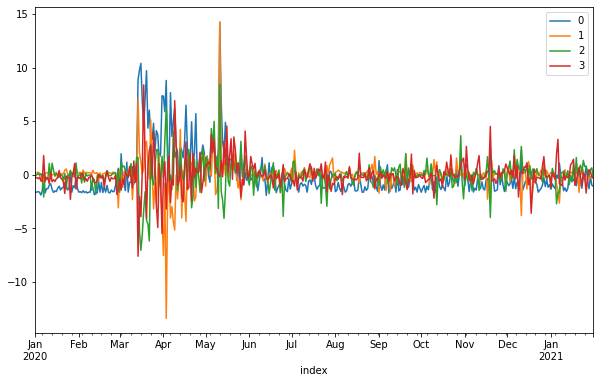

In [112]:
acp_axes_df = pd.DataFrame(indiv_pca, index=X.index)#, columns=["disparition", "crise", "sanitaire/hygiène", "?"])
acp_axes_df.resample("D").sum().plot(figsize=FIGSIZE)

# 2. Sentiment analysis (using pre-trained model)

In [27]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModel

def df_chunks(df, n):
    """Yield successive n-sized chunks from dataframe."""
    for i in range(0, len(df), n):
        yield df.iloc[i:i + n]


def get_model(model_name="nlptown/bert-base-multilingual-uncased-sentiment"):
    """For more models see: https://huggingface.co/models?filter=fr&pipeline_tag=text-classification
    Good models:
    nlptown/bert-base-multilingual-uncased-sentiment
    tblard/tf-allocine --> not working, error 404
    DemangeJeremy/4-sentiments-with-flaubert -> error: The model 'FlaubertModel' is not supported for sentiment-analysis.
    moussaKam/barthez-sentiment-classification # à tester
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
    
    return classifier


def tag_df(df, classifier, col_to_tag="tweet", row_size=15):
    gen_chunk_df = df_chunks(df=df[[col_to_tag]], n=ROW_SIZE)
    l = []
    
    for df_it in tqdm.tqdm(list(gen_chunk_df)):
        text_list = df_it[col_to_tag].tolist()
        sentiments = pd.DataFrame(classifier(text_list))
        df_out = pd.concat([df_it.reset_index(), sentiments], axis=1).set_index("index")
        l.append(df_out)
    
    return pd.concat(l)

In [29]:
classifier = get_model("nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
ROW_SIZE = 15 # chunk row size

In [66]:
df_sentiment = tag_df(df=df.loc[df.mask_covid], classifier=classifier, row_size=ROW_SIZE)

100%|██████████| 174/174 [02:32<00:00,  1.14it/s]


In [69]:
df_sentiment["stars"] = df_sentiment.label.str.split().str.get(0).astype(int)
df_sentiment["probs"] = df_sentiment.score.tolist()
df_sentiment.drop(columns=["label", "probs"], inplace=True)

#### Plot

In [71]:
stdev = df_sentiment.loc["2020":].resample("M")["stars"].std()
means = df_sentiment.loc["2020":].resample("M")["stars"].mean()

<AxesSubplot:xlabel='index'>

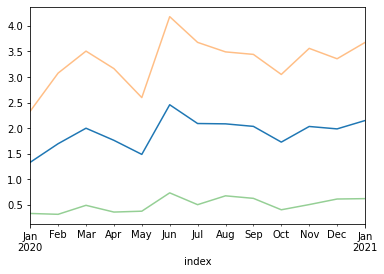

In [72]:
ax = means.plot()
(means + stdev).plot(ax=ax, alpha=.5)
(means - stdev).plot(ax=ax, alpha=.5)